(100,) (30, 100)


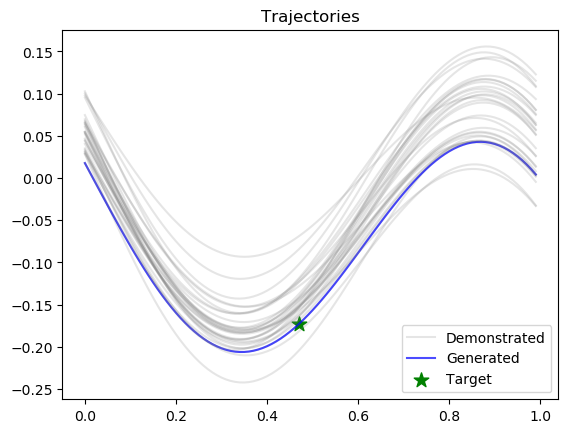

In [3]:
### Following code uses movement_primitives and gmr packages
### To install the packages, run the following commands on Python>3.6:
### pip install movement_primitives[all]
### pip install gmr[all]

from movement_primitives.promp import ProMP
from movement_primitives.dmp import DMP
from gmr import GMM
import numpy as np
import matplotlib.pyplot as plt


x = np.arange(0,1.00,0.01)
nrTraj=30
sigmaNoise=0.02

A = np.array([.2, .2, .01, -.05])
X = np.vstack((np.sin(5*x), x**2, x, np.ones((1,len(x)))))
Y = np.zeros((nrTraj, len(x)))

for traj in range(nrTraj):
    sample = -np.dot(A + sigmaNoise * np.random.randn(1,4), X)[0]
    Y[traj] = sample
    label = 'Demonstrated' if traj==0 else ''
    plt.plot(x, sample, 'gray', label=label, alpha=0.2)

    if traj == 5:
        plt.plot(x, sample, 'b', alpha=0.7, label='Generated')
        plt.scatter(x[47], sample[47], marker='*', c='green', s=120, label='Target')

plt.legend()
plt.title('Trajectories')

print(x.shape, Y.shape)

simple = np.concatenate((np.expand_dims(Y, -1), np.expand_dims(Y,-1)), axis=-1)
for i in range(Y.shape[0]):
    simple[i,:,0] = x

# import os

# save_path = '../data/synthetic/simple'

# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# for i in range(Y.shape[0]):
#     s = simple[i].reshape((1, simple.shape[1], simple.shape[2]))
#     # print(s.shape)
#     np.save(f'{save_path}/{i}.npy', s)

In [2]:
msp = np.mean(Y[:, 0])   # Average start
mep = np.mean(Y[:, -1])   # Average end
print(msp, mep)

0.04775195310965962 0.03409654309164747


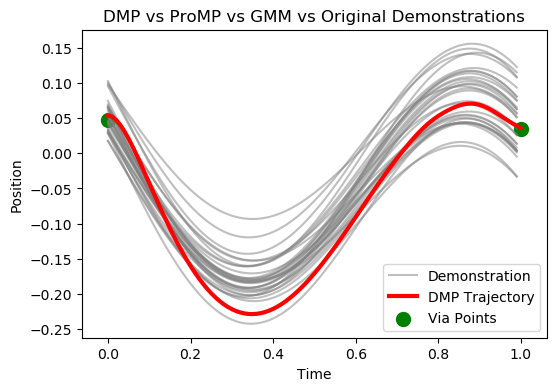

In [5]:
d = DMP(n_dims=1, n_weights_per_dim=20, dt=0.01)

plt.rcParams['figure.figsize'] = [6, 4]

for i, traj in enumerate(Y):
    d.imitate(x, traj.reshape(-1,1))
    plt.plot(x, traj, color='gray', label='Demonstration' if i==0 else '', alpha=0.5)  # Original trajectories in gray

d.configure(start_y=[msp], goal_y=[mep])
t, trajectory = d.open_loop()

p = ProMP(n_dims=1, n_weights_per_dim=20)
p.imitate(np.tile(x, (30, 1)), Y)

p = p.condition_position(msp, t=0).condition_position(mep, t=1)

trajectory_p = p.sample_trajectories(x, 1, np.random.RandomState(seed=1234))

input_data = x.reshape(-1, 1)  # Phase variable as a column vector
output_data = Y

priors = 20  # Number of GMM components
gmr_model = GMM(n_components=priors, random_state=1234)
gmr_model.from_samples(Y)
gmr_model = gmr_model.condition([0, -1], [msp, mep])
trajectory_g = gmr_model.sample(1)
trajectory_g = np.insert(trajectory_g, 0, msp)
trajectory_g = np.append(trajectory_g, mep)

plt.plot(x, trajectory_p[0,:,0], label='ProMP Trajectory', color='blue', linewidth=3)
plt.plot(t, trajectory, label='DMP Trajectory', color='red', linewidth=3)
plt.plot(x, trajectory_g, label='GMM Trajectory', color='magenta', linewidth=3)

plt.scatter([0, 1], [msp, mep], color='green', label='Via Points', s=100)  # Via points
plt.legend(loc='best')
plt.title('DMP vs ProMP vs GMM vs Original Demonstrations')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

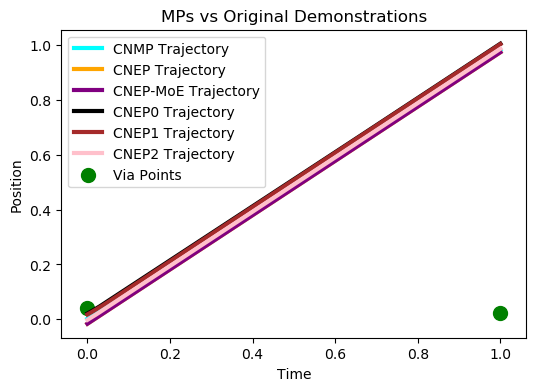

In [15]:
import torch
import sys

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnmp import CNMP
from cnep import CNEP

root_path = f"/home/yigit/projects/cnep/outputs/ablation/unimodal/orig_0_1_2_cnmp/"
run_id, model_folder = '1716801204', '/saved_models/'
models_path = f'{root_path}{run_id}{model_folder}'

m_path, m0_path, m1_path, m2_path, m3_path = f'{models_path}org.pt', f'{models_path}abl0.pt', f'{models_path}abl1.pt', f'{models_path}abl2.pt', f'{models_path}cnmp.pt'

batch_size = 1
dx, dy = 1, 1
n_max, m_max = 6, 6
t_steps = 100
device = 'cpu'

cnmp = CNMP(dx, dy, n_max, m_max, [64,64], decoder_hidden_dims=[64,64], batch_size=batch_size, device=device)
cnep = CNEP(dx, dy, n_max, m_max, [64,64], num_decoders=1, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)
cnep0 = CNEP(dx, dy, n_max, m_max, [64,64], num_decoders=1, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)
cnep1 = CNEP(dx, dy, n_max, m_max, [64,64], num_decoders=1, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)
cnep2 = CNEP(dx, dy, n_max, m_max, [64,64], num_decoders=1, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)

cnep.load_state_dict(torch.load(m_path, map_location='cpu'))
cnep0.load_state_dict(torch.load(m0_path, map_location='cpu'))
cnep1.load_state_dict(torch.load(m1_path, map_location='cpu'))
cnep2.load_state_dict(torch.load(m2_path, map_location='cpu'))
cnmp.load_state_dict(torch.load(m3_path, map_location='cpu'))



# data for testing cnxp
val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
# val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

val_obs.fill_(0)
val_tar_x.fill_(0)
val_obs_mask.fill_(False)

val_obs_mask[0, :2] = True

val_tar_x[0] = torch.linspace(0, 1, t_steps).unsqueeze(1)
val_obs[0, :2, :dx] = torch.tensor([0, 1]).unsqueeze(1)
val_obs[0, :2, dx:] = torch.tensor([msp, mep]).unsqueeze(1)

with torch.no_grad():
    trajectory_cnmp = cnmp.val(val_obs, val_tar_x, val_obs_mask)[:, :, :dy].squeeze(0)
    pred_cnep, gate = cnep.val(val_obs, val_tar_x, val_obs_mask)
    dec_id = torch.argmax(gate.squeeze(1), dim=-1)
    trajectory_cnep = pred_cnep[dec_id, 0, :, :dy]

    confs = gate.view(1, 1, 1, 1)
    preds = pred_cnep[:, :, :, :dy]

    weighted_preds = preds * confs  # Element-wise multiplication, shape (4, 1, 200, 1)
    trajectory_cnep_moe = weighted_preds.sum(dim=0, keepdim=True)  # Sum along the first dimension, shape (1, 1, 200, 1)
    trajectory_cnep_moe = trajectory_cnep_moe.squeeze(0).squeeze(0)

    pred_cnep0, gate0 = cnep0.val(val_obs, val_tar_x, val_obs_mask)
    dec_id0 = torch.argmax(gate0.squeeze(1), dim=-1)
    trajectory_cnep0 = pred_cnep0[dec_id0, 0, :, :dy]

    pred_cnep1, gate1 = cnep1.val(val_obs, val_tar_x, val_obs_mask)
    dec_id1 = torch.argmax(gate1.squeeze(1), dim=-1)
    trajectory_cnep1 = pred_cnep1[dec_id1, 0, :, :dy]

    pred_cnep2, gate2 = cnep2.val(val_obs, val_tar_x, val_obs_mask)
    dec_id2 = torch.argmax(gate2.squeeze(1), dim=-1)
    trajectory_cnep2 = pred_cnep2[dec_id2, 0, :, :dy]


# plt.plot(x, trajectory_p[0,:,0], label='ProMP Trajectory', color='blue', linewidth=3)
# plt.plot(t, trajectory, label='DMP Trajectory', color='red', linewidth=3)
# plt.plot(x, trajectory_g, label='GMM Trajectory', color='magenta', linewidth=3)
plt.plot(x, trajectory_cnmp[:,0], label='CNMP Trajectory', color='cyan', linewidth=3)
plt.plot(x, trajectory_cnep[:,0], label='CNEP Trajectory', color='orange', linewidth=3)
plt.plot(x, trajectory_cnep_moe[:,0], label='CNEP-MoE Trajectory', color='purple', linewidth=3)
plt.plot(x, trajectory_cnep0[:,0], label='CNEP0 Trajectory', color='black', linewidth=3)
plt.plot(x, trajectory_cnep1[:,0], label='CNEP1 Trajectory', color='brown', linewidth=3)
plt.plot(x, trajectory_cnep2[:,0], label='CNEP2 Trajectory', color='pink', linewidth=3)

plt.scatter([0, 1], [msp, mep], color='green', label='Via Points', s=100)  # Via points
plt.legend(loc='best')
plt.title('MPs vs Original Demonstrations')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

In [12]:
trajectory_cnmp[:,0]

tensor([0.0018, 0.0110, 0.0202, 0.0294, 0.0386, 0.0478, 0.0570, 0.0662, 0.0754,
        0.0846, 0.0938, 0.1030, 0.1125, 0.1225, 0.1325, 0.1425, 0.1525, 0.1625,
        0.1725, 0.1825, 0.1925, 0.2025, 0.2125, 0.2225, 0.2325, 0.2425, 0.2525,
        0.2625, 0.2725, 0.2825, 0.2925, 0.3025, 0.3125, 0.3225, 0.3325, 0.3425,
        0.3525, 0.3625, 0.3725, 0.3825, 0.3925, 0.4025, 0.4125, 0.4225, 0.4325,
        0.4425, 0.4525, 0.4625, 0.4725, 0.4825, 0.4925, 0.5025, 0.5125, 0.5225,
        0.5325, 0.5425, 0.5525, 0.5625, 0.5725, 0.5825, 0.5925, 0.6025, 0.6125,
        0.6225, 0.6325, 0.6425, 0.6525, 0.6625, 0.6725, 0.6825, 0.6925, 0.7025,
        0.7125, 0.7225, 0.7325, 0.7425, 0.7525, 0.7625, 0.7725, 0.7825, 0.7925,
        0.8025, 0.8125, 0.8225, 0.8325, 0.8425, 0.8525, 0.8625, 0.8725, 0.8825,
        0.8925, 0.9025, 0.9125, 0.9225, 0.9325, 0.9425, 0.9525, 0.9625, 0.9725,
        0.9825])